In [0]:
#from google.colab import files

#files.upload()

In [0]:
#!pip install tensorflow==2.0.0-alpha0

In [3]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.gridspec import GridSpec as GS
from matplotlib import pyplot as plt
from datetime import datetime
import tensorflow as tf
import pandas as pd
import numpy as np

# Load in BTC historical data
price_data = pd.read_csv('BTC-USD.csv')

# Load and preprocess sentiment data 
sentiment_data1 = pd.read_csv('btc_sentiment.csv', header = None)
sentiment_data2 = pd.read_csv('btc_sentiment2.csv', header = None)
sentiment_data  = pd.concat([sentiment_data1, sentiment_data2])

# The table contains UTC time and Positive/Negative/Neutral/Composite sentiment values
#   for every comment containing the word "bitcoin" on reddit in the past 730 days
sentiment_data.columns = ['utc','pos','neg','neu','comp']
sentiment_data = sentiment_data.sort_values('utc', ascending = True)

# Lambda function to contain long if/else construct
date_format = lambda a: "{}-0{}-0{}".format(a.year, a.month, a.day) if( a.month < 10 and a.day < 10) \
else "{}-0{}-{}".format(a.year, a.month, a.day) if( a.month < 10 and a.day >= 10) \
else "{}-{}-0{}".format(a.year, a.month, a.day) if( a.month >= 10 and a.day < 10) \
else "{}-{}-{}".format(a.year, a.month, a.day)

# Function to covert UTC time to YYYY-MM-DD
def date_converter(item):
  a = datetime.date(datetime.fromtimestamp(item))
  return date_format(a)

# Preprocess data using date_converter()
sentiment_data['Date'] = sentiment_data.utc.apply(lambda x: date_converter(x))
sentiment_data = sentiment_data.reset_index()
sentiment_data = sentiment_data[['Date','pos','neg','neu','comp']]

# List of unique dates 
dates = sentiment_data.Date.unique().tolist()
dates_int = {i:day for i, day in enumerate(dates)}

# Get daily comment frequency and normalized sentiment values
freq, pos, neg, neu, comp = [],[],[],[],[]
for date in dates:
    freq.append( len(sentiment_data[sentiment_data.Date==date]))
    pos.append(  sentiment_data[sentiment_data.Date==date]['pos'].sum()  )
    neg.append(  sentiment_data[sentiment_data.Date==date]['neg'].sum()  )
    neu.append(  sentiment_data[sentiment_data.Date==date]['neu'].sum()  )
    comp.append( sentiment_data[sentiment_data.Date==date]['comp'].sum() )

# Save as arrays and normalize
freq = np.array(freq)
pos  = np.array(pos)/freq
neg  = np.array(neg)/freq
neu  = np.array(neu)/freq
comp = np.array(comp)/freq

# Save opening and closing prices for stock 
open_price  =  np.array(price_data['Open'])
close_price =  np.array(price_data['Close'])
high_price =   np.array(price_data['High'])
low_price =    np.array(price_data['Close'])

# Stock all columns together
data = np.column_stack((freq, pos, neg, neu, comp, open_price, close_price))
data = MinMaxScaler().fit_transform(data)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

In [0]:
cols = ['Frequency', 'Positive Sentiment', 'Negative Sentiment', 'Neutral Sentiment', 'Composite Sentiment', 'Open Price', 'High Price', 'Low Price', 'Closing Price']

# Function for visual analysis
def inspect_correlation(index):
  plt.figure(figsize = (24,8))
  gs = GS(nrows = 5, ncols = 2, width_ratios = [2,1])
  gs.update(hspace = 0.0, wspace = 0.01)
  for i in range(9):
    if i < 5:
      ax = plt.subplot(gs[i,0])
      ax.set_ylim(0,1)
      ax.plot(data[:, i], label = "Price / {}".format(cols[i]), alpha = 0.3, c='k')
      ax.plot(data[:, -1], alpha = 0.7, c='k')
    else:
      ax=plt.subplot(gs[:,1])
      alph = 0.1 if i!=index else 0.8
      ax.scatter(data[:, -1], data[:, i-5], label = "Closing price vs {}".format(cols[i-5]), alpha=alph)
      ax.axis([0,1,0,1])
    plt.legend(loc=3, fontsize=8 )
    plt.grid()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


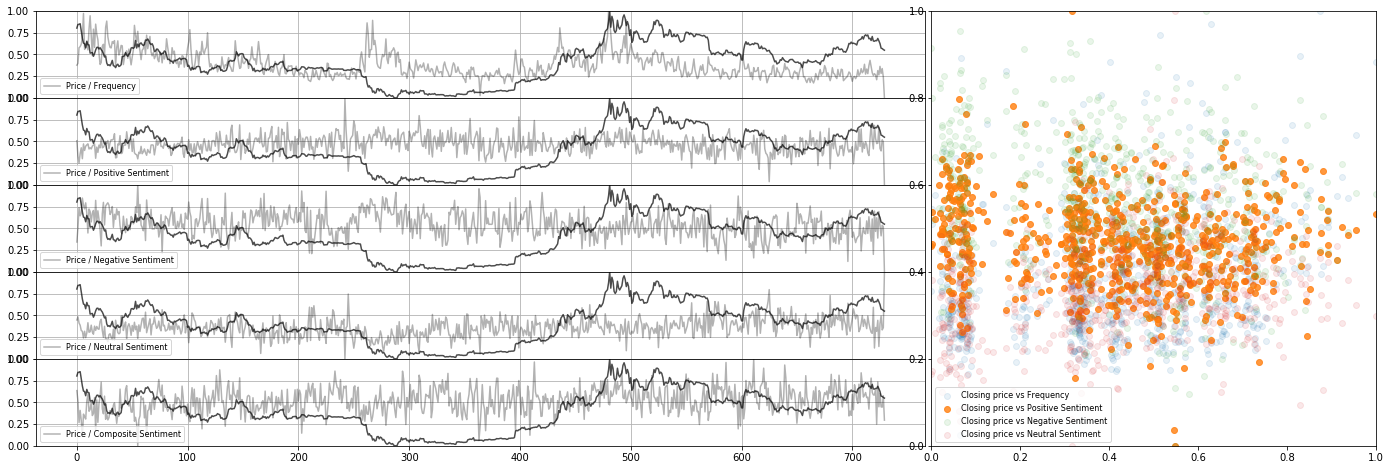

In [5]:
# Using, 5, 6, 7, or 8 as an input, this function highlights the relationship between our various features and closing price
inspect_correlation(6)

In [0]:
# Funtion to turn our time series data into set of sequences where the last value is the intended output of our model
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    ser = tf.expand_dims(series, axis=-1)
    data = tf.data.Dataset.from_tensor_slices(series)
    data = data.window(window_size + 1, shift=1, drop_remainder=True)
    data = data.flat_map(lambda w: w.batch(window_size + 1))
    data = data.shuffle(shuffle_buffer)
    data = data.map(lambda w: (w[:-1], w[1:]))
    return data.batch(batch_size).prefetch(1)

# Funciton to plot times series
def plot_series(time, series, label, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.grid(True)

# Function to format get model prediction
def model_forecast(model, X, window_size):
    data = tf.data.Dataset.from_tensor_slices(X)
    data = data.window(window_size, shift=1, drop_remainder=True)
    data = data.flat_map(lambda w: w.batch(window_size))
    data = data.batch(32).prefetch(1)
    forecast = model.predict(data)
    return forecast

In [7]:
#```````````````````````````````````````````````````````````````````````````````````````````````` 
#  The following parameters can all be adjusted to change the size/shape of our input tensors
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
 window_size = 30               # Length of sequences used to train model
 batch_size = 128               # Number of batches per epoch of training
 shuffle_buffer_size = 100      # Number of points kept in memory to draw samples from
 col_indices = [-1 , 0 , 1 , -2]           # Column indices for desired features
 split_time = 630               # Where split series into training/validation sets
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# Create arrays of time series data and numerical dates
X = np.array(data[:, col_indices])
time = np.array([i for i, day in enumerate(dates)])

# Split into training and validation sets
time_train, x_train = time[:split_time], X[:split_time]
time_valid, x_valid = time[split_time:], X[split_time:]


# Clear metadata and set random seeds for replicability
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

# Generate data
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Build model
model = tf.keras.models.Sequential([
  
  # CONVOLUTIONAL LAYER
  tf.keras.layers.Conv1D(filters=64,
                         kernel_size=15,
                         strides=1,
                         padding="causal",
                         activation="relu",
                         input_shape=[None,len(col_indices)]),
  # LSTM LAYER
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(30, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(30, return_sequences=True)),

  # CONVOLUTIONAL LAYER
  tf.keras.layers.Conv1D(filters=16,
                         kernel_size=5,
                         strides=1,
                         padding="causal",
                         activation="relu"),

  # DENSE LAYER
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1),

  # LAMBDA LAYER
  tf.keras.layers.Lambda(lambda x: 256.0 * x )
])

# Vary learning rate over our training to find optimal value 
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

# Stochastic Gradient Descent optimizer
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

# Compile model using Huber loss, SGD and learning rate scheduler
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model.summary()
history = model.fit(train_set, epochs=100, callbacks=[lr_scheduler], verbose = 1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 64)          3904      
_________________________________________________________________
bidirectional (Bidirectional (None, None, 60)          22800     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 60)          21840     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          4816      
_________________________________________________________________
dense (Dense)                (None, None, 64)          1088      
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           6

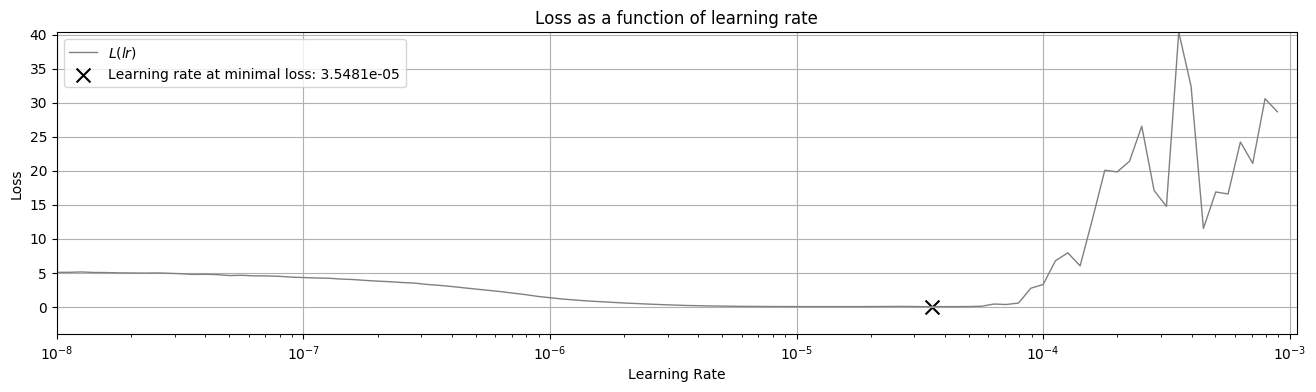

In [8]:
# Calulate optimal learning rate
loss_history = history.history['loss']
lr_history = history.history['lr']
performance = {mae:lr for lr, mae in zip(lr_history, loss_history)}
lr_optimal = performance[min(loss_history)]

# Plot results
plt.figure(figsize=(16,4), dpi=120)
plt.title("Loss as a function of learning rate")
plt.xlabel("Learning Rate")
plt.ylabel('Loss')
plt.semilogx(lr_history, loss_history, label='$L(lr)$', c='gray', lw=1)

# Label minimum loss
plt.scatter([lr_optimal],[min(loss_history)], marker='x', s=100, label = "Learning rate at minimal loss: {}".format('%.4e' % lr_optimal), c='k')
plt.axis([min(lr_history), max(lr_history)+(max(lr_history)-min(lr_history))*0.2, min(loss_history)-(max(loss_history)-min(loss_history))*0.1, max(loss_history)])
plt.legend()
plt.grid()

In [18]:
#```````````````````````````````````````````````````````````````````````````````````````````````` 
#  The following parameters can all be adjusted to change the size/shape of our input tensors
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
 window_size = 15               # Length of sequences used to train model
 batch_size = 128               # Number of batches per epoch of training
 shuffle_buffer_size = 100      # Number of points kept in memory to draw samples from
 col_indices = [-1 , 0 , -2]    # Column indices for desired features
 split_time = 630               # Where split series into training/validation sets
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# Create arrays of time series data and numerical dates
time = np.array([i for i, day in enumerate(dates)])
X = np.array(data[:, col_indices])

# Split into training and validation sets
time_train, x_train = time[:split_time], X[:split_time]
time_valid, x_valid = time[split_time:], X[split_time:]


# Clear metadata and set random seeds for replicability
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)


train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64,
                         kernel_size=15,
                         strides=1,
                         padding="causal",
                         activation="relu",
                         input_shape=[None,len(col_indices)]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(90, return_sequences=True)),
  tf.keras.layers.Conv1D(filters=64,
                         kernel_size=5,
                         strides=1,
                         padding="causal",
                         activation="relu"),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True)),  
  tf.keras.layers.Dense(64, activation='tanh'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: 16.0 * x )
])


# Compile and train the model
model.compile(loss = 'mse',
#    loss = tf.keras.losses.Huber(),
    optimizer = tf.keras.optimizers.SGD(
        lr = lr_optimal,
        momentum = 0.9),
    metrics = ["mae"])
model.summary()
history = model.fit(train_set, epochs = 150, verbose = 1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 64)          2944      
_________________________________________________________________
bidirectional (Bidirectional (None, None, 180)         111600    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          57664     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 100)         46000     
_________________________________________________________________
dense (Dense)                (None, None, 64)          6464      
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           65        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

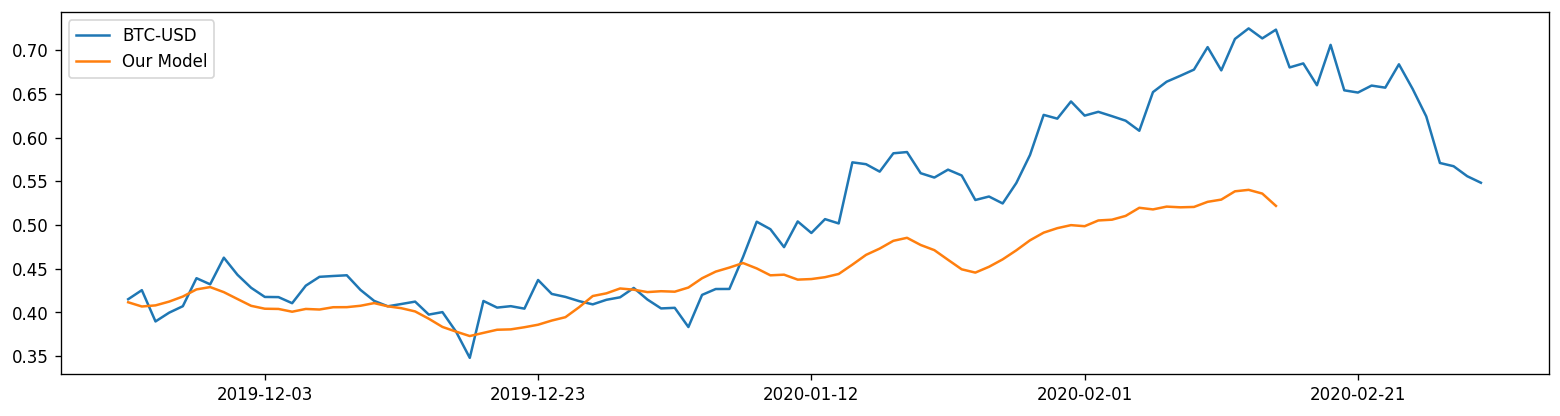

In [22]:
forecast = model_forecast(model, x_valid[...], window_size)
plt.figure(figsize = (16, 4), dpi=120)
plt.plot(time_valid, x_valid[:, 0], label="BTC-USD")
plt.plot(time_valid[:-window_size], forecast[:-1,-1,0], label='Our Model')
plt.xticks([i*20+600 for i in range(2,7)],labels = [dates[i*20+600] for i in range(2,7)])
plt.legend()

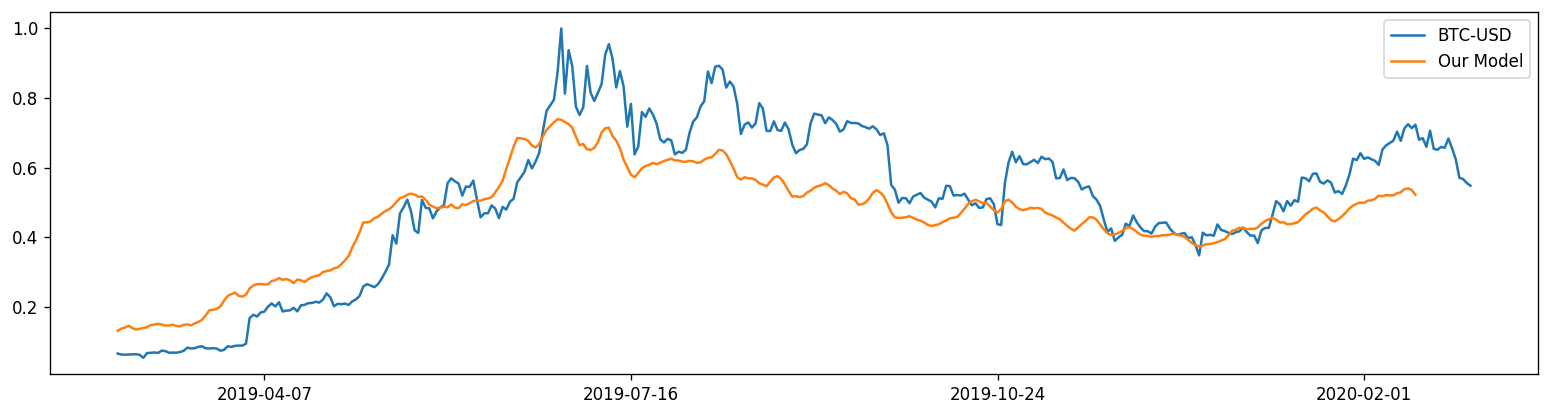

In [24]:

forecast = model_forecast(model, X[...], window_size)
plt.figure(figsize = (16, 4), dpi=120)
plt.plot(time[360:], X[360:, 0], label="BTC-USD")
plt.plot(time[360:-window_size], forecast[360:-1,-1,0], label='Our Model')
plt.xticks([i*100 for i in range(4,8)],labels = [dates[i*100] for i in range(4,8)])
plt.legend()